GGCNN(
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3))
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (convt1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convt2): ConvTranspose2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (convt3): ConvTranspose2d(16, 32, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3), output_padding=(1, 1))
  (pos_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (cos_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (sin_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (width_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
)
Loading YCB Dataset...
ALL IMAGE LISTS ARE CREATED!
Depth Image List:['/home/i53/student/b_woerz/Documents/ycb_sim_data_1/ycb_simulation_sample_001_master_chef_can/depth_img

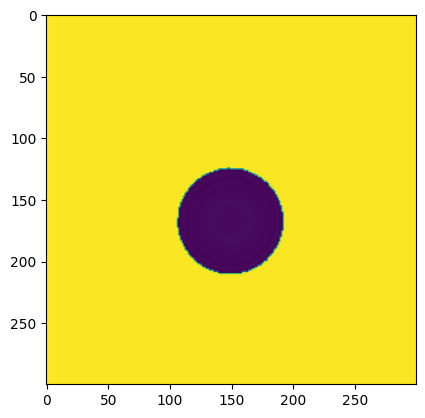

In [5]:
# import Dataset classes for Cornell and Jaquard 
# (inherit from GraspDatasetbase which inherits from torch.utils.data.Dataset)
from utils.data.cornell_data import CornellDataset
from utils.data.jacquard_data import JacquardDataset
from utils.data.ycb_data import YCBDataset

import torch

# import model
from models.ggcnn import GGCNN

# import post processing function (convert raw output GG-CNN to numpy arrays and apply filtering)
from models.common import post_process_output

import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# define arguments
weights_path = '/home/i53/student/b_woerz/ggcnn2/ggcnn_weights_cornell/ggcnn_epoch_23_cornell_statedict.pt'
model_path = '/home/i53/student/b_woerz/ggcnn2/ggcnn_weights_cornell/ggcnn_epoch_23_cornell'
dataset_name = 'YCB'
dataset_path = '/home/i53/student/b_woerz/Documents/ycb_sim_data_1'
use_depth = 1       # 'Use Depth image for evaluation (1/0)'
use_rgb = 0         # 'Use RGB image for evaluation (0/1)'
augment = True      # 'Whether data augmentation should be applied')
split = 0.9         # 'Fraction of data for training (remainder is validation)'
ds_rotate = 0.0     # 'Shift the start point of the dataset to use a different test/train split')
num_workers = 8     # 'Dataset workers'
n_grasps = 1        # 'Number of grasps to consider per image')

Dataset = YCBDataset



model = GGCNN()
model.load_state_dict(torch.load(weights_path,map_location=torch.device('cuda')))
print(model)


if __name__ == '__main__':
    
    # Load Network
    net = torch.load(model_path)
    device = torch.device("cuda:0")

    # Load Dataset
    print('Loading {} Dataset...'.format(dataset_name))
    logging.info('Loading {} Dataset...'.format(dataset_name))
    
    test_dataset = Dataset(dataset_path, start=split, end=1.0, ds_rotate=ds_rotate,
                           random_rotate=augment, random_zoom=augment,
                           include_depth=use_depth, include_rgb=use_rgb)
    
    test_data = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers
    )
    logging.info('Done')

    obj_counter = 0
    with torch.no_grad():
        for idx, (x, didx, rot, zoom) in enumerate(test_data):
            logging.info('Processing {}/{}'.format(idx+1, len(test_data)))
            xc = x.to(device)
            
            #visualize input depth image
            x = np.squeeze(x)
            imgplot1 = plt.imshow(x)

            pred = net.forward(xc) #-> pos_output, cos_output, sin_output, width_output
            print('PREDICTION: Type: {}, Shape: {}'.format(type(pred), len(pred)))
            q_img, ang_img, width_img = post_process_output(pred['pos'], pred['cos'], pred['sin'], pred['width'] )
            obj_counter += 1
            

print('Position: {}, Type: {}, Shape: {}'.format(q_img, type(q_img), q_img.shape))
print('Angle: Type: {}, Shape: {}'.format(type(ang_img), ang_img.shape))
print('Width: Type: {}, Shape: {}'.format(type(width_img), width_img.shape))
print('Number of objects: {}'.format(obj_counter))

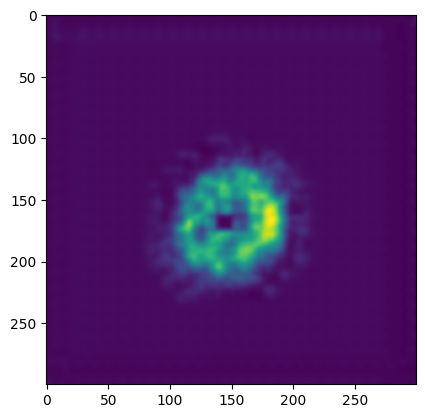

In [6]:


imgplot2 = plt.imshow(q_img)


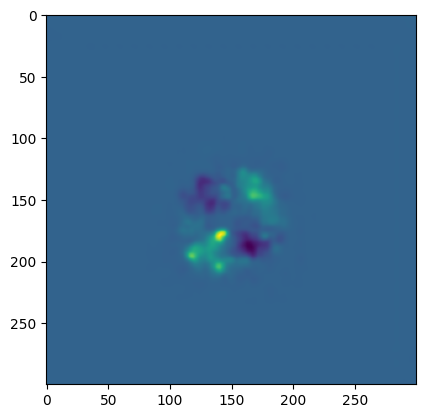

In [7]:
imgplot3 = plt.imshow(ang_img)

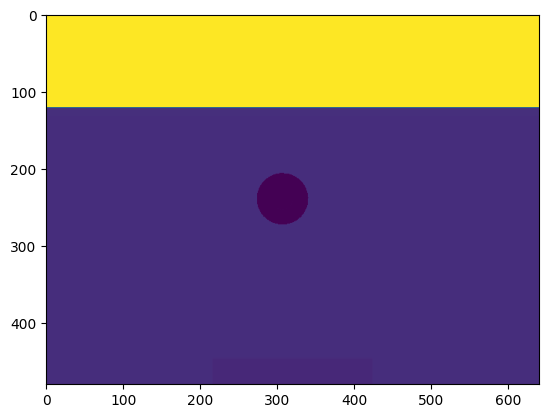

In [8]:
from utils.dataset_processing import grasp, image
depth_img = image.DepthImage.from_npy('/home/i53/student/b_woerz/Documents/ycb_sim_data_1/ycb_simulation_sample_001_master_chef_can/depth_img.npy')
rgb_img = image.DepthImage.from_npy('/home/i53/student/b_woerz/Documents/ycb_sim_data_1/ycb_simulation_sample_001_master_chef_can/rgb_img.npy')
imgplot4 = plt.imshow(depth_img)
#imgplot4 = plt.imshow(rgb_img)